# [WIP] Retrieval Augmented Generation (RAG) with Hamilton
This notebook presents a tutorial on how to build a RAG dataflow with Hamilton. We break down this dataflow into several steps:
1. **Ingestion**:
    1. get raw data (HTML, PDF, text, audio, etc.)
    2. preprocess text
    3. embed text
2. **Retrieval**: get relevant content for query
3. **Generation**: use generative AI to return an answer.

In [1]:
from hamilton import driver
%load_ext magic

In [2]:
%%set_display_config
orient = "TB"

# Chapter 1: Ingestion
First, we need to get raw documents.

## 1.1 Load a single document
- We define a container for Documents. It helps with type annotations. It could be anything though, even just a `dict`.

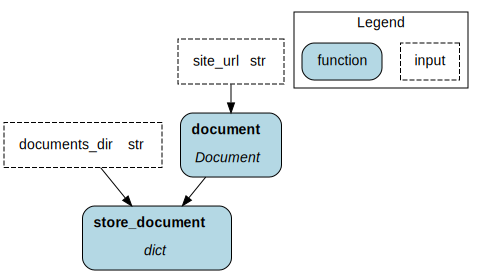

In [3]:
%%cell_to_module --module_name ingest --write_to_file --display
import uuid
from pathlib import Path
from typing import TypedDict

import requests
from hamilton.function_modifiers import config


class Chunk(TypedDict):
    """Chunk of a Document"""
    index: int
    document_id: str
    text: str
    embedding: list
    
    
class Document(TypedDict):
    """Document containing a full raw text,
    which can be decomposed in Chunks
    """
    id: str
    raw_text: str
    chunks: list[Chunk]


def _url_to_document_id(url: str) -> str:
    """Deterministic UUID based on url; this is safe for a filename"""
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, url))


def document(site_url: str) -> Document:
    """Get request an HTML page and create a full document from it."""
    document_id = _url_to_document_id(site_url)
    response = requests.get(site_url)
    return Document(id=document_id, raw_text=response.text)


def store_document(document: Document, documents_dir: str) -> dict:
    """Store document to disk if it doesn't already exist.
    Return a dictionary of metadata
    """   
    document_path = Path(documents_dir, f"{document.id}.html")
    
    if not document_path.exists():
        document_path.write_text(document['raw_text'])
        
    return get_file_metadata(document_path)

## 1.2 Preprocess document
We can assemble different routine for parsing, chunking, and embedding documents before storing them. 

/home/tjean/projects/dagworks/hamilton/examples/jupyter_notebook_magic/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


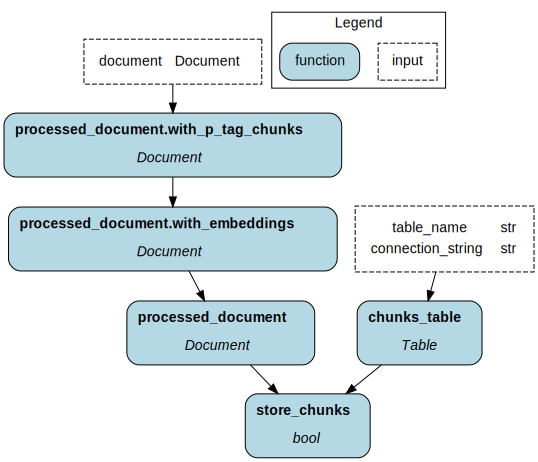

In [4]:
%%cell_to_module --module_name preprocess --write_to_file --display
import lancedb
from lancedb.table import Table
from hamilton.function_modifiers import pipe, step

from ingest import Document, Chunk  # import from our previous module

def _p_tag_chunks(document: Document) -> Document:
    """Create chunks from <p> HTML tags found under an <article> tag.
    If no <article> tag is found, create a single chunk with the full text.
    """
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(document.raw_text, features="lxml", parser="lxml")
    
    chunks = []
    if soup.article:
        for i, paragraph in enumerate(soup.article.find_all("p")):
            chunks.append(
                Chunk(index=i, document_id=document.id, text=paragraph)
            )
    # if contains no <article> tag
    else:
        chunks.append(Chunk(index=0, document_id=document.id, text=document.raw_text))
            
    document["chunks"] = chunks
    return document


def _embeddings(document: Document) -> Document:
    """Generate embeddings for each chunk of a document."""
    from sentence_transformers import SentenceTransformer
    
    if not document.chunks:
        raise ValueError("document.chunks is empty.")
    
    embedding_provider = SentenceTransformer(model_name)
    embeddings = embedding_provider.encode([c.text for c in document.chunks])
    
    for i, embedding in enumerate(embeddings):
        document.chunks[i]["embedding"] = embedding

    return document


@pipe(
    step(_p_tag_chunks),
    step(_embeddings),
)
def processed_document(document: Document) -> Document:
    """Assembles steps to preprocess document"""
    return document


def chunks_table(table_name: str, connection_string: str) -> Table:
    """Create LanceDB table to store peprocessed chunks"""
    db = lancedb.connect(connection_string)
    table = db.create_table(name=table_name, exist_ok=True)
    return table


def store_chunks(processed_document: Document, chunks_table: Table) -> bool:   
    """Store document in LanceDB table for chunks""" 
    count_before = chunks_table.count_rows()
    # returns nothing but has side-effects
    (
        chunks_table
        .merge_insert(on="document_id")
        .when_not_matched_insert_all()
        .execute(processed_document.chunks)
    )
    count_after = chunks_table.count_rows()
    return {"rows_added": count_after - count_before}

## 1.3 Add configuration for modular components
We want to try new preprocessing steps to achieve better performance and make code reusable across projects.

### Configure individual steps with `@pipe`
We can configure which individuals steps are included/execlude of a `@pipe` operator.

In [5]:
%%set_driver
# we set a config for our Driver
dr = (
    driver.Builder()
    .with_config({"embedding_provider": "hf"})  
    .build()
)

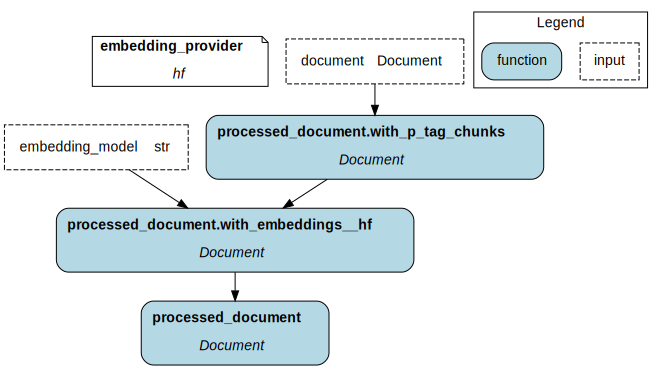

In [6]:
%%cell_to_module -m preprocess -d -w
from typing import TypedDict

from hamilton.function_modifiers import pipe, step, config, source, value

from ingest import Document, Chunk  # import from our previous module


def _p_tag_chunks(document: Document) -> Document:
    """Create chunks from <p> HTML tags found under an <article> tag.
    If no <article> tag is found, create a single chunk with the full text.
    """
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(document.raw_text, features="lxml", parser="lxml")
    
    chunks = []
    if soup.article:
        for i, paragraph in enumerate(soup.article.find_all("p")):
            chunks.append(
                Chunk(index=i, document_id=document.id, text=paragraph)
            )
    # if contains no <article> tag
    else:
        chunks.append(Chunk(index=0, document_id=document.id, text=document.raw_text))
            
    document["chunks"] = chunks
    return document


# implement alternative function implementations
def _embeddings__hf(document: Document, embedding_model: str) -> Document:
    """Generate embeddings for each chunk of document using models from HuggingFace
    and the SentenceTransformer library.
    """
    from sentence_transformers import SentenceTransformer
    
    if not document.chunks:
        raise ValueError("document.chunks is empty.")
    
    embedding_provider = SentenceTransformer(model_name)
    embeddings = embedding_provider.encode([c.text for c in document.chunks])
    
    for i, embedding in enumerate(embeddings):
        document.chunks[i]["embedding"] = embedding

    return document

# implement alternative function implementations
def _embeddings__openai(document: Document, embedding_model: str) -> Document:
    """Generate embeddings for each chunk of document using the OpenAI API."""
    import openai
    ... 
    return document

# we can include / exclude steps of our pipeline using the Driver config.
@pipe(
    step(_p_tag_chunks),
    step(_embeddings__hf, embedding_model=source("embedding_model")).when(embedding_provider="hf"),
    step(_embeddings__openai, embedding_model=source("embedding_model")).when(embedding_provider="openai"),
)
def processed_document(document: Document) -> Document:
    """Assembles steps to preprocess document"""
    return document

### Configure sets of steps with `@config`

In [7]:
%%set_driver
dr = (
    driver.Builder()
    .with_config({"version": "candidate"})
    .build()
)

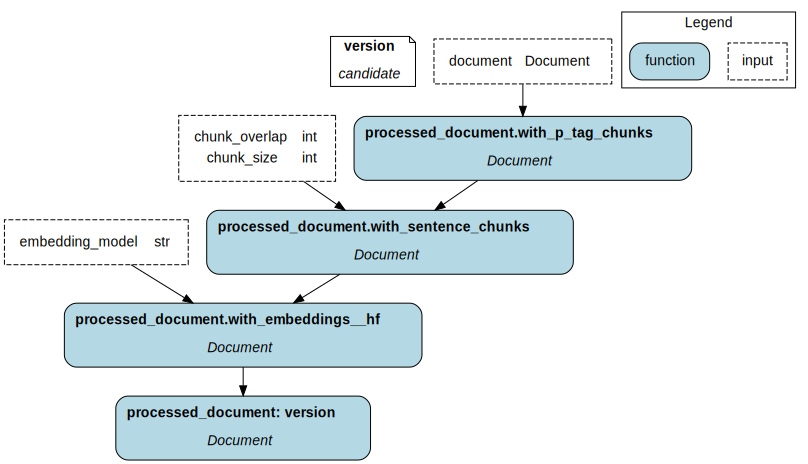

In [8]:
%%cell_to_module -m pipe_config -d
from typing import TypedDict

from hamilton.function_modifiers import pipe, step, config, source, value

from ingest import Document, Chunk  

def _p_tag_chunks(document: Document) -> Document:
    """Create chunks from <p> HTML tags found under an <article> tag.
    If no <article> tag is found, create a single chunk with the full text.
    """
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(document.raw_text, features="lxml", parser="lxml")
    
    chunks = []
    if soup.article:
        for i, paragraph in enumerate(soup.article.find_all("p")):
            chunks.append(
                Chunk(index=i, document_id=document.id, text=paragraph)
            )
    # if contains no <article> tag
    else:
        chunks.append(Chunk(index=0, document_id=document.id, text=document.raw_text))
            
    document["chunks"] = chunks
    return document


def _sentence_chunks(document: Document, chunk_size: int = 256, chunk_overlap: int = 32) -> Document:
    """Further chunk document chunks using recursive character splitting."""
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    
    chunker = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    # if Document wasn't previously chunked
    if not document.chunks:
        document["chunks"] = [document.raw_text]
        
    chunks = []
    for c in document.chunks:
        for i, text in enumerate(chunker.split_text(c.text)):
            chunks.append(
                Chunk(
                    index=i, document_id=document.id, text=text
                )
            )
            
    document["chunks"] = chunks
    return document
    

def _embeddings__hf(document: Document, embedding_model: str) -> Document:
    """Generate embeddings for each chunk of document using models from HuggingFace
    and the SentenceTransformer library.
    """
    if not document.chunks:
        raise ValueError("document.chunks is empty.")
    
    text_chunks = [c.text for c in document.chunks]
    
    from sentence_transformers import SentenceTransformer
    embedding_provider = SentenceTransformer(model_name)
    embeddings = embedding_provider.encode(text_chunks, convert_to_numpy=True)
    
    for i, embedding in enumerate(embeddings):
        document.chunks[i]["embedding"] = embedding

    return document


def _embeddings__openai(document: Document, embedding_model: str) -> Document:
    """Generate embeddings for each chunk of document using the OpenAI API."""
    import openai
    ... 
    return document


# step() no longer have config
# instead the config applies to the entire `processed_document` function
@config.when(version="production")
@pipe(
    step(_p_tag_chunks),
    step(_embeddings__openai, embedding_model=source("embedding_model"))
)
def processed_document__production(document: Document) -> Document:
    """Assembles steps to preprocess document"""
    return document


@config.when(version="candidate")
@pipe(
    step(_p_tag_chunks),
    step(_sentence_chunks),
    step(_embeddings__hf, embedding_model=source("embedding_model"))
)
def processed_document__candidate(document: Document) -> Document:
    """Assembles steps to preprocess document"""
    return document

## 1.4 Parallelize multiple documents
So far, we've processed a single document. Once you have that logic though, you can use that code in a loop defined by `Parallelizable/Collect` nodes.

In [9]:
%%set_driver
import ingest, preprocess

dr = (
    driver.Builder()
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_modules(ingest, preprocess)
    .build()
)

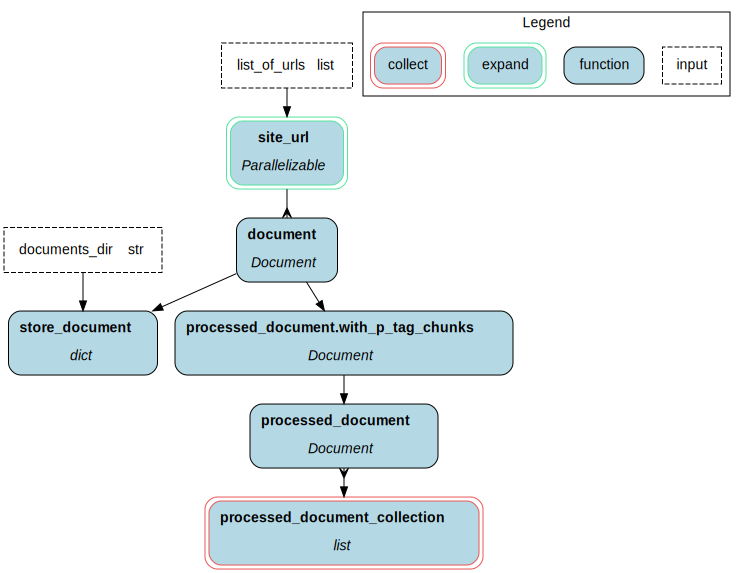

In [10]:
%%cell_to_module -m parallel_ingestion -d -w
import lancedb
from lancedb.table import Table
from hamilton.function_modifiers import config
from hamilton.htypes import Collect, Parallelizable

from ingest import Document


def site_url(list_of_urls: list[str]) -> Parallelizable[str]:
    """Iterate over urls to query"""
    for url in list_of_urls:
        yield url
    

def processed_document_collection(processed_document: Collect[dict]) -> list[Document]:    
    """Collected processed document in a list"""
    return list(processed_document)

# Chapter 2: Retrieval
Now, when doing vector search, it's important to use the same embedding model for the documents and the user query. To do so, we import embedding functions from the module `preprocess` defined previously.

In [11]:
%%set_driver
dr = (
    driver.Builder()
    .with_config(dict(embedding_provider="openai"))
    .build()
)

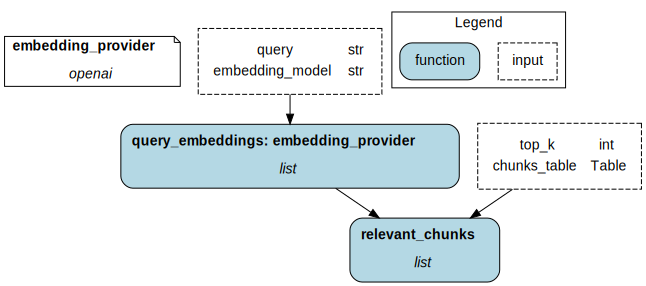

In [12]:
%%cell_to_module -m retrieval -d -w
import pandas as pd
from lancedb.table import Table
from hamilton.function_modifiers import pipe, step, source, config

from preprocess import _embeddings__openai, _embeddings__hf


@config.when(embedding_provider="openai")
def query_embeddings__openai(query: str, embedding_model: str) -> list:
    """Wrap the query in a document and get its embedding using OpenAI"""
    document = _embeddings__openai(document={"chunks": [query]}, model_name=embedding_model)
    return document.chunks.embeddings[0]


@config.when(embedding_provider="hf")
def query_embeddings__hf(query: str, embedding_model: str) -> list:
    """Wrap the query in a document and get its embedding using HuggingFace
    and SentenceTransformer
    """
    document = _embeddings__hf(document={"chunks": [query]}, model_name=embedding_model)
    return document.chunks.embeddings[0]


def relevant_chunks(
    chunks_table: Table,
    query_embeddings: list,
    top_k: int = 10
) -> list[str]:
    """Use LanceDB to conduct vector similarity search between query and stored documents."""
    return (
        chunks_table
        .search(query_embeddings)
        .limit(top_k)
        .to_list()
    )

# Chapter 3: Generation

Other tips:
- Batch LLM requests
- Use CachingAdapter to save credits during development

In [13]:
%%cell_to_module -wm generation 
import textwrap

def instructions() -> str:
    """System prompt to inform the LLM behavior."""
    return textwrap.dedent(
        """You are a helpful assistant. You must provide factual accuracy
        given the context you're provided at all time. If some information
        is conflicting, highlight that in your response
        """
    )

    
def context(relevant_chunks: list[str]) -> str:
    """Join text chunks retrieved by skipping lines between them."""
    return "\n\n".join(relevant_chunks)


def query_prompt(query: str, context: str) -> str:
    """Wrap the query and context in a template"""
    return textwrap.dedent(
        f"""{query}
                    
        CONTEXT
        {context}
            
        ANSWER
        """
    )


def generative_answer(query_prompt: str, instructions: str, generative_model: str) -> str:
    """Generate an answer using an OpenAI chat model"""
    response = openai.ChatCompletion.create(
        model=generative_model,
        messages=[{"role": "user", "content": query_prompt}],
        temperature=0
    )
    return response["choices"][0]["message"]["content"]

# Putting it all together!
Load all modules in a single Driver to view the full dataflow

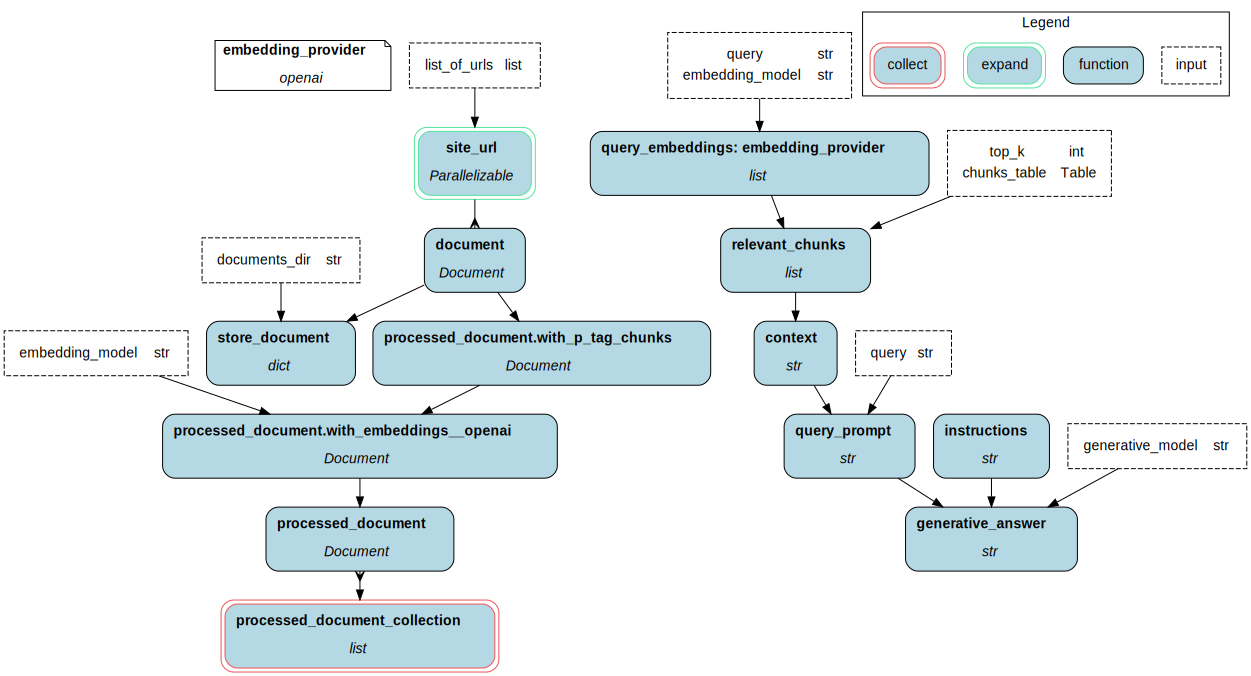

In [14]:
import ingest, preprocess, retrieval, generation, parallel_ingestion

dr = (
    driver.Builder()
    .with_modules(ingest, preprocess, retrieval, generation, parallel_ingestion)
    .with_config(dict(embedding_provider="openai"))
    .build()
)
dr.display_all_functions(orient="TB")

# Chapter 4: Evaluation
Nobody figured out evaluation yet, but Hamilton makes it easy to write. 

First think about the dimensions to tune:
- documents to include for retrieval: deduplication, chunk selection
- how documents are preprocessed: chunking, parsing, 
- retrieval strategy: vector, metadata, hybrid, agentic (e.g., chain of thought)
- prompt tuning: wording, how prompt include retrieved content
- generative model: LLM provider, finetuning, model merging
- answer post-processing: validating code, format text, content moderation

Then, select the steps of your RAG application that you want to optimize. Think about the cost and tradeoff of the steps you're optimizing. For example, reprocessing all documents means having to recompute embeddings, and any change upstream of the LLM requires generating new answers. 

In [15]:
%%set_driver
# reset the previously defined drivers
dr = (
    driver.Builder()
    .build()
)

### Define alternative pipelines with `@subdag`
In the next cell, we define two retrieval + generation pipeline using `@subdag`. The `openai_rag` uses OpenAI embeddings while the `os_rag` uses HuggingFace embeddings. Both use OpenAI for generative answers.

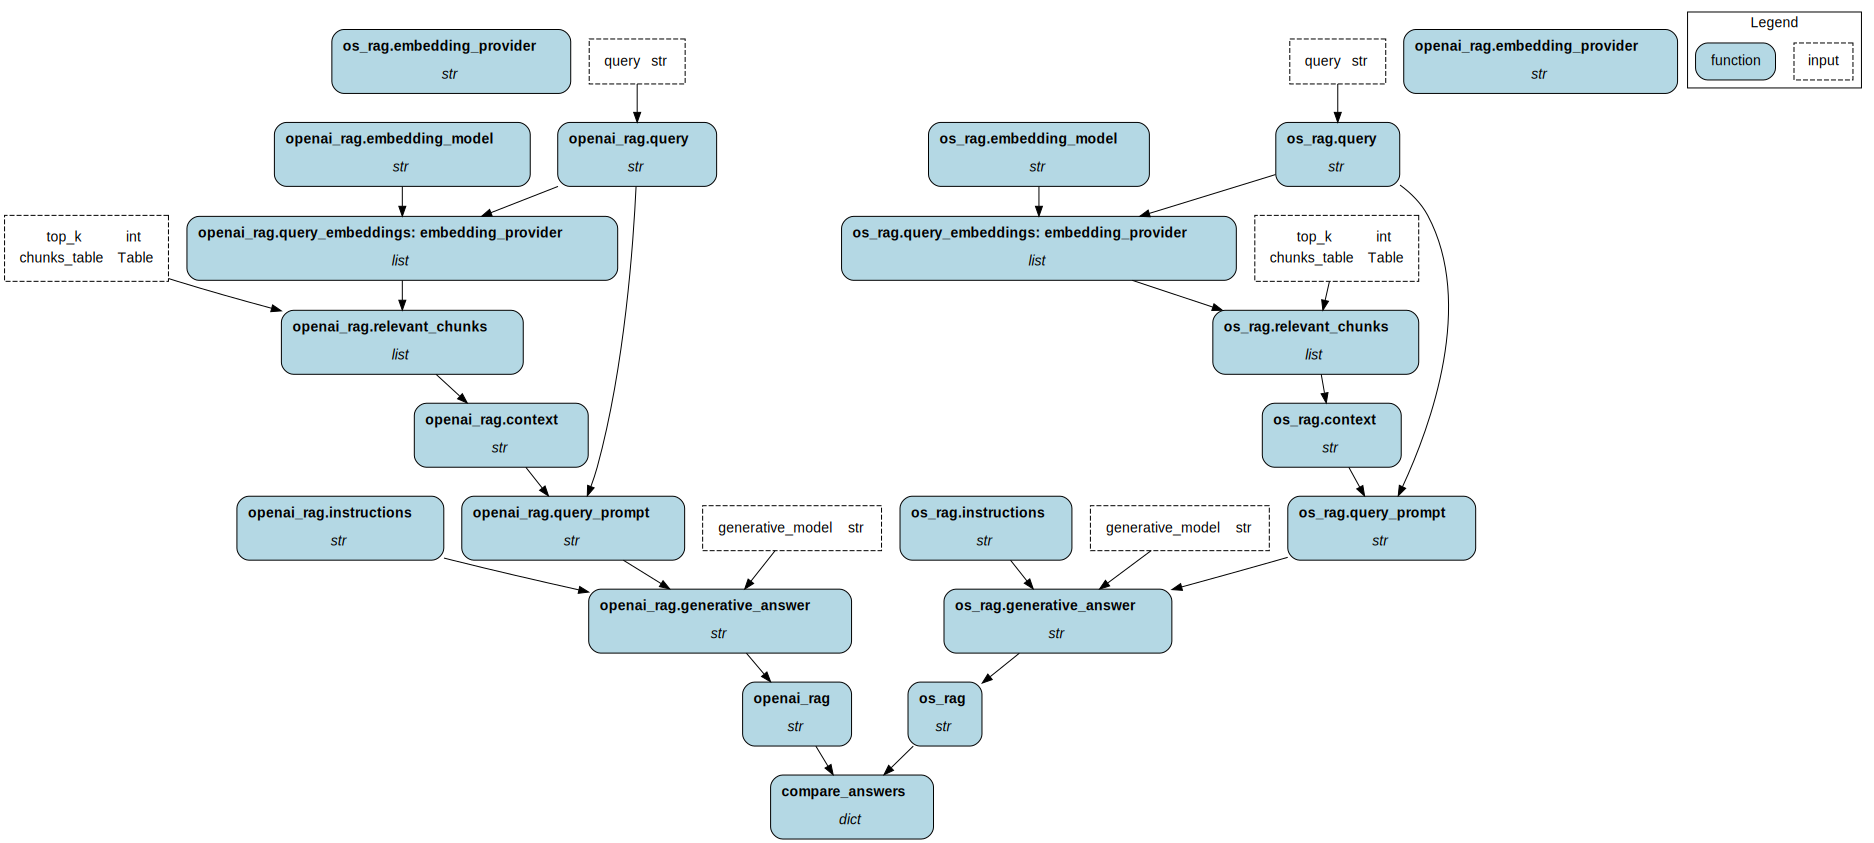

In [18]:
%%cell_to_module -m evaluation -d -w

from hamilton.function_modifiers import subdag, source, value

import retrieval, generation


@subdag(
    retrieval, generation,
    config=dict(embedding_provider="openai"),
    inputs=dict(query=source("query"), embedding_model=value("ada")),
)
def openai_rag(generative_answer: str) -> str:
    return generative_answer


@subdag(
    retrieval, generation,
    config=dict(embedding_provider="hf"),
    inputs=dict(query=source("query"), embedding_model=value("bte")),
)
def os_rag(generative_answer: str) -> str:
    return generative_answer


def compare_answers(openai_rag: str, os_rag: str) -> dict:
    return ...